In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter



from functions.EpiIndex import *
from functions.Connectivity import *

In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)
#Reading a npy file 
data_alpha = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_distance_dense.npy')
data_hgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_distance_dense.npy')

#Data with other metrics
data_coh = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/SR_subseg_connectivity_data_high_freq_coh_dense.npy')[:,:,:,0]
# Assuming data is the array with shape (50, 127, 127)
for i in range(data_coh.shape[0]):
    # Extract the lower triangular part (including the diagonal)
    lower_triangular = np.tril(data_coh[i])
    
    # Mirror the lower triangular part to the upper triangular part
    data_coh[i] = lower_triangular + lower_triangular.T - np.diag(np.diag(lower_triangular))

#Make data_coh symmetric

# con_data=np.mean(data,axis=3)
raw=raw.drop_channels(["lp'11", "lp'12", "op'12", "pi'18", "pa'12"])

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif...


Isotrak not found
    Range : 4681728 ... 4866048 =   9144.000 ...  9504.000 secs
Ready.


/tmp/ipykernel_295239/614534963.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)


Reading 0 ... 184320  =      0.000 ...   360.000 secs...


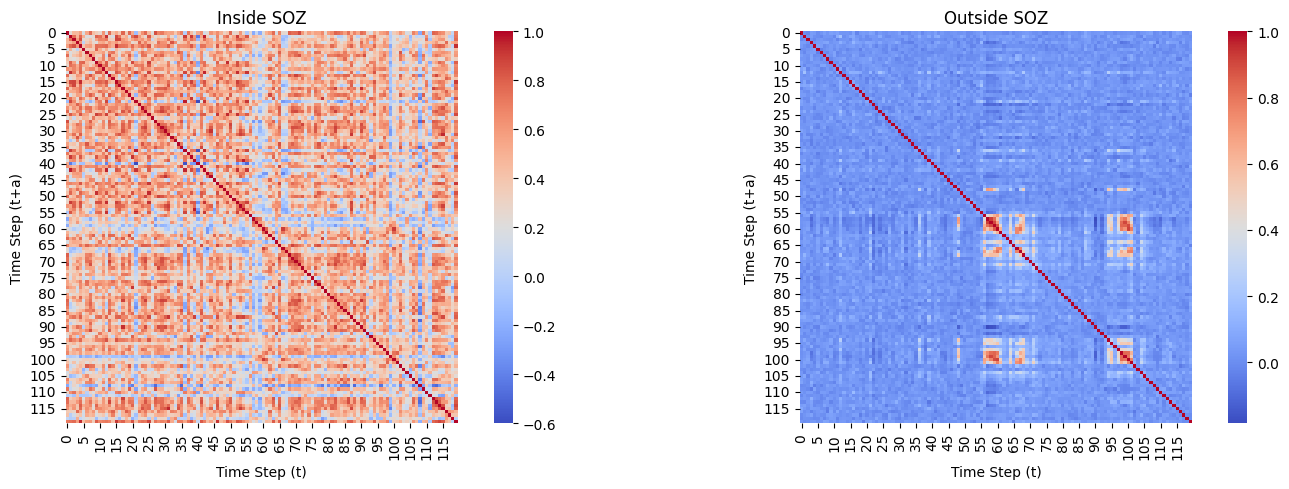

In [4]:
#For this data set, we are going to get the temporal correlation of the channels inside, outside, inside vs outside
#the SOZ
ch_names=raw.ch_names
data=data_lgamma_norm
data.shape

#Get the SOZ channels
inside_channels=["sc'3","sc'4","sc'5","sc'6","y'5","y'6","y'7","y'8","y'9"]
#Get the channels outside the SOZ 
outside_channels=[ch for ch in raw.ch_names if ch not in inside_channels]

#Get the indices of the channels
inside_channels_idx=[ch_names.index(ch) for ch in inside_channels]
outside_channels_idx=[ch_names.index(ch) for ch in outside_channels]

#From data, get the subset of matrix with the channels inside the SOZ
data_inside=data[:,inside_channels_idx,:][:,:,inside_channels_idx]
#From data, get the subset of matrix with the channels outside the SOZ
data_outside=data[:,outside_channels_idx,:][:,:,outside_channels_idx]

#Get the correlation of the channels inside the SOZ
correlation_inside = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_inside[t1, :, :][np.triu_indices_from(data_inside[t1, :, :], k=1)]
        upper_tri_2 = data_inside[t2, :, :][np.triu_indices_from(data_inside[t2, :, :], k=1)]
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_inside[t1, t2] = correlation

#Get the correlation of the channels outside the SOZ
correlation_outside = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_outside[t1, :, :][np.triu_indices_from(data_outside[t1, :, :], k=1)]
        upper_tri_2 = data_outside[t2, :, :][np.triu_indices_from(data_outside[t2, :, :], k=1)]
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_outside[t1, t2] = correlation



#Plot the correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(correlation_inside, fmt=".2f", cmap='coolwarm', square=True, ax=axs[0])
axs[0].set_title("Inside SOZ")
axs[0].set_xlabel("Time Step (t)")
axs[0].set_ylabel("Time Step (t+a)")

sns.heatmap(correlation_outside, fmt=".2f", cmap='coolwarm', square=True, ax=axs[1])
axs[1].set_title("Outside SOZ")
axs[1].set_xlabel("Time Step (t)")
axs[1].set_ylabel("Time Step (t+a)")
plt.tight_layout()
plt.show()


Para empezar a hacer el proceso de optimizaciòn, vamos primero a fijar la època, y la frequencia

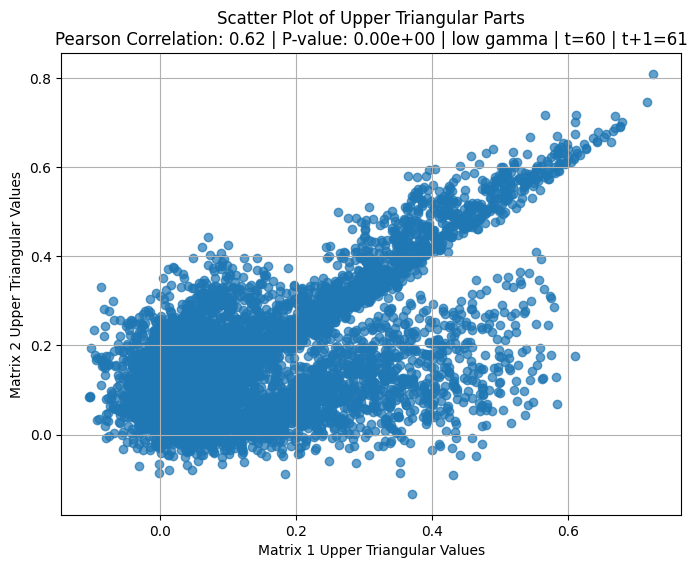

Pearson correlation coefficient: 0.62
P-value: 0.00e+00


In [19]:
data=data_hgamma_norm
f='low gamma'
t=60
# Extract the upper triangular parts, excluding the diagonal
upper_tri_1 = data_outside[t,:,:][np.triu_indices_from(data_outside[t,:,:], k=1)]
upper_tri_2 = data_outside[t+1,:,:][np.triu_indices_from(data_outside[t+1,:,:], k=1)]

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(upper_tri_1, upper_tri_2)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(upper_tri_1, upper_tri_2, alpha=0.7)
plt.title(f'Scatter Plot of Upper Triangular Parts\nPearson Correlation: {correlation:.2f} | P-value: {p_value:.2e} | {f} | t={t} | t+1={t+1}')
plt.xlabel('Matrix 1 Upper Triangular Values')
plt.ylabel('Matrix 2 Upper Triangular Values')
plt.grid(True)
plt.show()

print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")


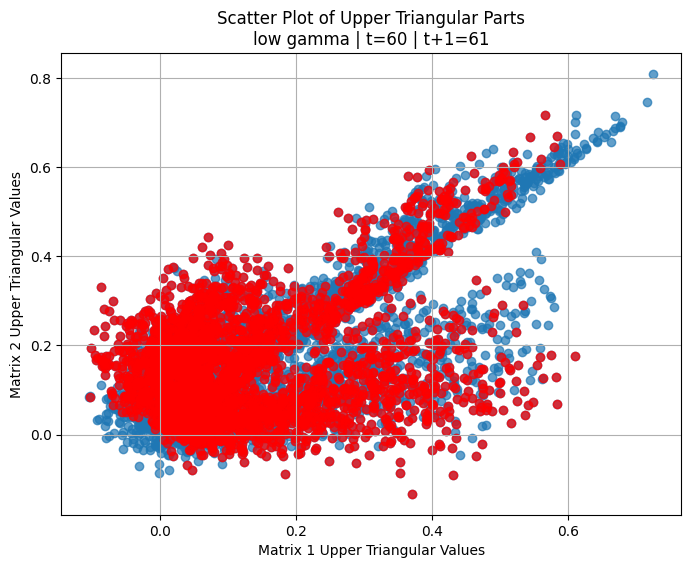

In [23]:
#The idea is that we are going to substract points in the scatter plot, and we are going to see how the correlation
#changes. A point is going to be subtracted if the pearson correlation 
#improves.

# Create a list to store the correlation coefficients

correlation_coefficients = []
p_values = []
#Get an array of the tuples with the names of the channels
ch_names_tup=[(ch_names[i],ch_names[j]) for i,j in zip(np.triu_indices_from(data_outside[t, :, :], k=1)[0],np.triu_indices_from(data_outside[t, :, :], k=1)[1])]
# Create a list to store the indices of the points to be removed
points_to_remove = []

for i in range(upper_tri_1.size):
    # Create a mask to exclude the i-th point
    mask = np.ones(upper_tri_1.size, dtype=bool)
    mask[i] = False

    # Calculate Pearson correlation coefficient
    correlation, p_value = pearsonr(upper_tri_1[mask], upper_tri_2[mask])

    # Append the correlation coefficient to the list
    correlation_coefficients.append(correlation)
    p_values.append(p_value)

    # If the correlation coefficient is greater than the previous one, add the index to the list
    if i > 0 and correlation > correlation_coefficients[i - 1]:
        points_to_remove.append(i)

# Create scatter plot with the points to be removed 
plt.figure(figsize=(8, 6))
plt.scatter(upper_tri_1, upper_tri_2, alpha=0.7)
plt.scatter(upper_tri_1[points_to_remove], upper_tri_2[points_to_remove], color='red', alpha=0.7)
plt.title(f'Scatter Plot of Upper Triangular Parts\n{f} | t={t} | t+1={t+1}')
plt.xlabel('Matrix 1 Upper Triangular Values')
plt.ylabel('Matrix 2 Upper Triangular Values')
plt.grid(True)
plt.show()


# Another approach using signal processing

In [3]:
# Lets segment our raw data into epochs
epochs=mne.make_fixed_length_epochs(raw, duration=6, preload=True)


Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 3072 original time points ...
0 bad epochs dropped


In [ ]:
#Let calculate the time-frequency representation of the data using Morlet wavelets
frequencies = np.logspace(1, 2, num=50)

# Calculate the time-frequency representation of the data
power, phase_locking = spectral_connectivity_epochs(epochs, method='wpli2_debiased', sfreq=raw.info['sfreq'], fmin=1, fmax=100, faverage=True, faverage_params=dict(frequencies=frequencies, use_fft=False))

# Get the time points
